In [1]:
!wget /content/A3DS.zip
!unzip A3DS.zip

/content/A3DS.zip: Scheme missing.
Archive:  A3DS.zip
replace __MACOSX/._A3DS? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Packages



In [2]:
from transformers import GPT2TokenizerFast, ViTImageProcessor, VisionEncoderDecoderModel
from torch.utils.data import Dataset
from torchtext.data import get_tokenizer
import requests
import torch
import numpy as np
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


## Loading the pretrained model and its helper components



In [3]:
model_raw = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

In [4]:
image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer       = GPT2TokenizerFast.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

## Generating captions



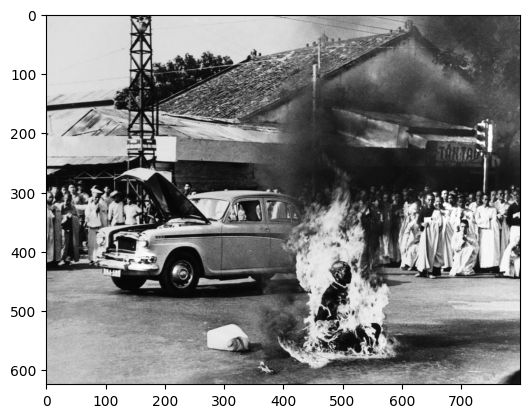

The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


an old truck in the middle of a fire 


In [5]:
def show_n_generate(url, greedy = True, model = model_raw):
    image = Image.open(requests.get(url, stream =True).raw)
    pixel_values   = image_processor(image, return_tensors ="pt").pixel_values
    plt.imshow(np.asarray(image))
    plt.show()

    if greedy:
        generated_ids  = model.generate(pixel_values, max_new_tokens = 30)
    else:
        generated_ids  = model.generate(
            pixel_values,
            do_sample=True,
            max_new_tokens = 30,
            top_k=5)
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(generated_text)

#url = "http://images.cocodataset.org/val2017/000000039769.jpg"
#url = "https://raw.githubusercontent.com/michael-franke/npNLG/main/neural_pragmatic_nlg/pics/06-3DS-example.jpg"
#url = "https://img.welt.de/img/sport/mobile102025155/9292509877-ci102l-w1024/hrubesch-rummenigge-BM-Berlin-Gijon-jpg.jpg"
url = "https://faroutmagazine.co.uk/static/uploads/2021/09/The-Cover-Uncovered-The-severity-of-Rage-Against-the-Machines-political-message.jpg"
# url = "https://media.npr.org/assets/img/2022/03/13/2ukraine-stamp_custom-30c6e3889c98487086d76869f8ba6a8bfd2fd5a1.jpg"

show_n_generate(url, greedy = False)

## Fine-tuning on the A3DS data set



In [6]:
class A3DS(Dataset):
    def __init__(
            self,
            path="A3DS",
            num_labels=1, # number of ground truth labels to retrieve per image
            labels_type="long", # alternative: short
            run_inference=False, # depending on this flag, check presence of model weights
            batch_size=1,
            vocab_file="vocab.pkl",
            start_token="START",  # might be unnecessary since vocab file is fixed anyways
            end_token="END",
            unk_token="UNK",
            pad_token="PAD",
            max_sequence_length=26, # important for padding length
        ):

        # check vocab file exists
        assert os.path.exists(os.path.join(path, vocab_file)), "Make sure the vocab file exists in the directory passed to the dataloader (see README)"

        # check if image file exists
        assert (os.path.exists(os.path.join(path, "sandbox_3Dshapes_1000.pkl")) and os.path.join(path, "sandbox_3Dshapes_resnet50_features_1000.pt")), "Make sure the sandbox dataset exists in the directory passed to the dataloader (see README)"

        if labels_type == "long":
            assert num_labels <= 20, "Maximally 20 distinct image-long caption pairs can be created for one image"
        else:
            assert num_labels <= 27, "Maximally 27 distinct image-short caption pairs can be created for one image"

        self.batch_size = batch_size
        with open(os.path.join(path, vocab_file), "rb") as vf:
            self.vocab = pickle.load(vf)

        self.max_sequence_length = max_sequence_length
        self.start_token = start_token
        self.end_token = end_token
        self.unk_token = unk_token
        self.pad_token = pad_token
        self.tokenizer = get_tokenizer("basic_english")

        self.embedded_imgs = torch.load(os.path.join(path, "sandbox_3Dshapes_resnet50_features_1000.pt"))
        with open(os.path.join(path, "sandbox_3Dshapes_1000.pkl"), "rb") as f:
            self.sandbox_file = pickle.load(f)
            self.images = self.sandbox_file["images"]
            self.numeric_labels = self.sandbox_file["labels_numeric"]
            self.labels_long = self.sandbox_file["labels_long"]
            self.labels_short = self.sandbox_file["labels_short"]

        if labels_type == "long":
            labels_ids_flat = [list(np.random.choice(range(len(self.labels_long[0])), num_labels, replace=False)) for i in range(len(self.images))]
            self.labels_flat = [self.labels_long[i][l] for i, sublst in enumerate(labels_ids_flat) for l in sublst]
            self.img_ids_flat = [id for id in range(len(self.images)) for i in range(num_labels)]
        else:
            labels_ids_flat = [list(np.random.choice(range(len(self.labels_short[0])), num_labels, replace=False)) for i in range(len(self.images))]
            self.labels_flat = [self.labels_short[i][l] for i, sublst in enumerate(labels_ids_flat) for l in sublst]
            self.img_ids_flat = [id for id in range(len(self.images)) for i in range(num_labels)]

    def __len__(self):
        return len(self.img_ids_flat)

    def __getitem__(self, idx):
        # access raw image corresponding to the index in the entire dataset
        target_img = self.images[self.img_ids_flat[idx]]
        # access caption
        target_lbl = self.labels_flat[idx]
        # access original numeric annotation of the image
        numeric_lbl = self.numeric_labels[self.img_ids_flat[idx]]
        # cast type
        target_img = np.asarray(target_img).astype('uint8')
        # retrieve ResNet features, accessed through original image ID
        target_features = self.embedded_imgs[self.img_ids_flat[idx]]
        # tokenize label
        tokens = self.tokenizer(str(target_lbl).lower().replace("-", " "))
        # Convert caption to tensor of word ids, append start and end tokens.
        target_caption = self.tokenize_caption(tokens)
        # convert to tensor
        target_caption = torch.Tensor(target_caption).long()

        return target_img, target_features, target_lbl, numeric_lbl, target_caption

    def tokenize_caption(self, label):
        label = label[:(self.max_sequence_length-2)]
        tokens = [self.vocab["word2idx"][self.start_token]]
        for t in label:
            try:
                tokens.append(self.vocab["word2idx"][t])
            except:
                tokens.append(self.vocab["word2idx"][self.unk_token])
        tokens.append(self.vocab["word2idx"][self.end_token])
        # pad
        while len(tokens) < self.max_sequence_length:
            tokens.append(self.vocab["word2idx"][self.pad_token])

        return tokens

    def get_labels_for_image(self, id, caption_type="long"):
        if caption_type == "long":
            return self.labels_long[self.img_ids_flat[id]]
        else:
            return self.labels_short[self.img_ids_flat[id]]

A3DS_dataset = A3DS()
vocab = A3DS_dataset.vocab["word2idx"].keys()
vocab_size = len(vocab)

### Creating a &rsquo;DataLoader&rsquo;



In [7]:
batch_size = 1
A3DS_data_loader = torch.utils.data.DataLoader(
    dataset    = A3DS_dataset,
    batch_size = batch_size,
    shuffle    = True,
)

### Fine-tuning training



In [8]:
model_trained = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

optimizer = torch.optim.Adam(model_trained.parameters(), lr=1e-4)

for i in tqdm(range(len(A3DS_data_loader.dataset))):
    # get the next training instance
    x = next(iter(A3DS_data_loader))

    # retrieve and preprocess image
    image = x[0][0]
    image = Image.fromarray(image.detach().numpy()) # TODO: necessary?
    pixel_values = image_processor(image, return_tensors="pt").pixel_values

    # retrieve and preprocess labels
    labels = x[2][0]
    labels = tokenizer(labels, return_tensors="pt").input_ids

    # compute loss
    loss = model_trained(pixel_values=pixel_values, labels=labels).loss

    # parameter update
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 1000/1000 [1:24:22<00:00,  5.06s/it]


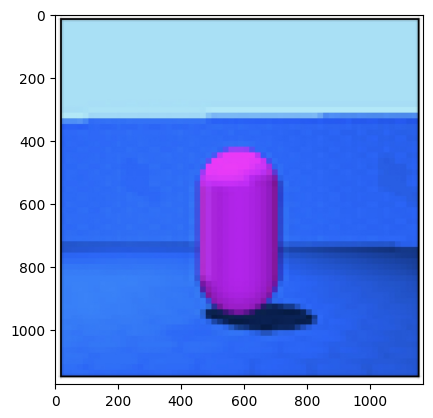

a small purple pill in the middle in front of a medium blue wall on medium blue floor is purple floor is large purple wall is purple pill on medium


In [11]:
url = "https://raw.githubusercontent.com/michael-franke/npNLG/main/neural_pragmatic_nlg/pics/06-3DS-example.jpg"

show_n_generate(url, greedy = False, model = model_trained)